<a href="https://colab.research.google.com/github/waelrash1/forecastingmodelsPY/blob/main/CH05/CH05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoregressive AR process

## This chapter will covers:
* Illustrating an autoregressive process
* Defining the partial autocorrelation function (PACF)
* Using the PACF plot to determine the order of an autoregressive process
*  Forecasting a time series using the autoregressive model

## Summary of MA process from previous chapter:

* Previous chapter covered moving average process denoted as MA(q), where q is the order.
* In a moving average process, present value depends linearly on current and past error terms.
* Predictions beyond q steps will fall flat and return only the mean of the series, as error terms are not observed in the data and must be recursively estimated.
* The order of a stationary MA(q) process can be determined by studying the ACF plot; autocorrelation coefficients will be significant up to lag q.
* If autocorrelation coefficients decay slowly or exhibit a sinusoidal pattern, it may indicate the presence of an autoregressive process.

### Import required Libs

In [1]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline



### Predicting the average weekly foot traffic in a retail store
Suppose that you want to forecast the average weekly foot traffic in a retail store so
that the store manager can better manage the staff’s schedule. If many people are
expected to come to the store, more employees should be present to provide assistance.
If fewer people are expected to visit the store, the manager can schedule fewer
employees to work. That way the store can optimize its spending on salaries and
ensure that employees are not overwhelmed or underwhelmed by store visitors.
For this example, we have 1,000 data points, each representing the average weekly
foot traffic at a retail store starting in the year 2000.

### Loading data

In [2]:

data_url='https://raw.githubusercontent.com/waelrash1/timeSeriesPy/master/data/foot_traffic.csv'

df = pd.read_csv(data_url)

df.head()


,foot_traffic
0,500.496714
1,500.522366
2,501.426876
3,503.295990
4,504.132695


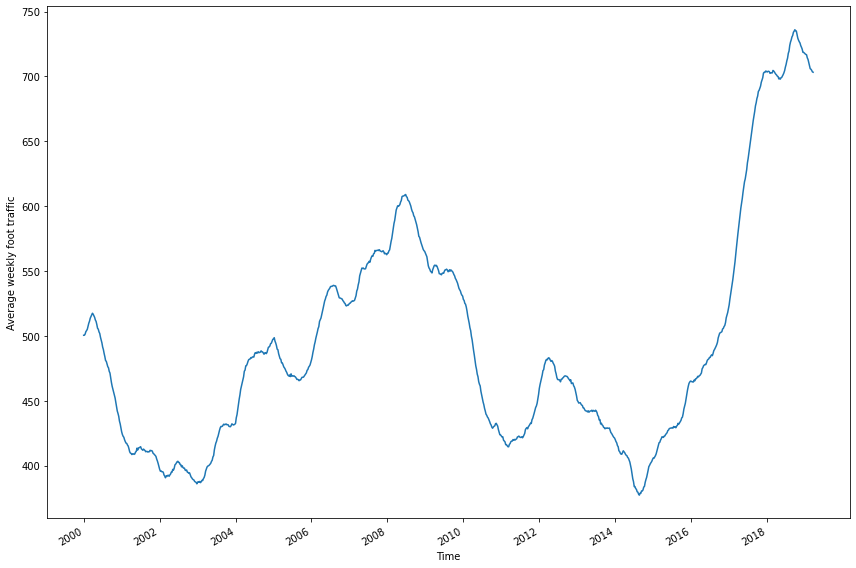

In [3]:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(df['foot_traffic'])
ax.set_xlabel('Time')
ax.set_ylabel('Average weekly foot traffic')

plt.xticks(np.arange(0, 1000, 104), np.arange(2000, 2020, 2))

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/CH05_F01_peixeiro.png', dpi=300)


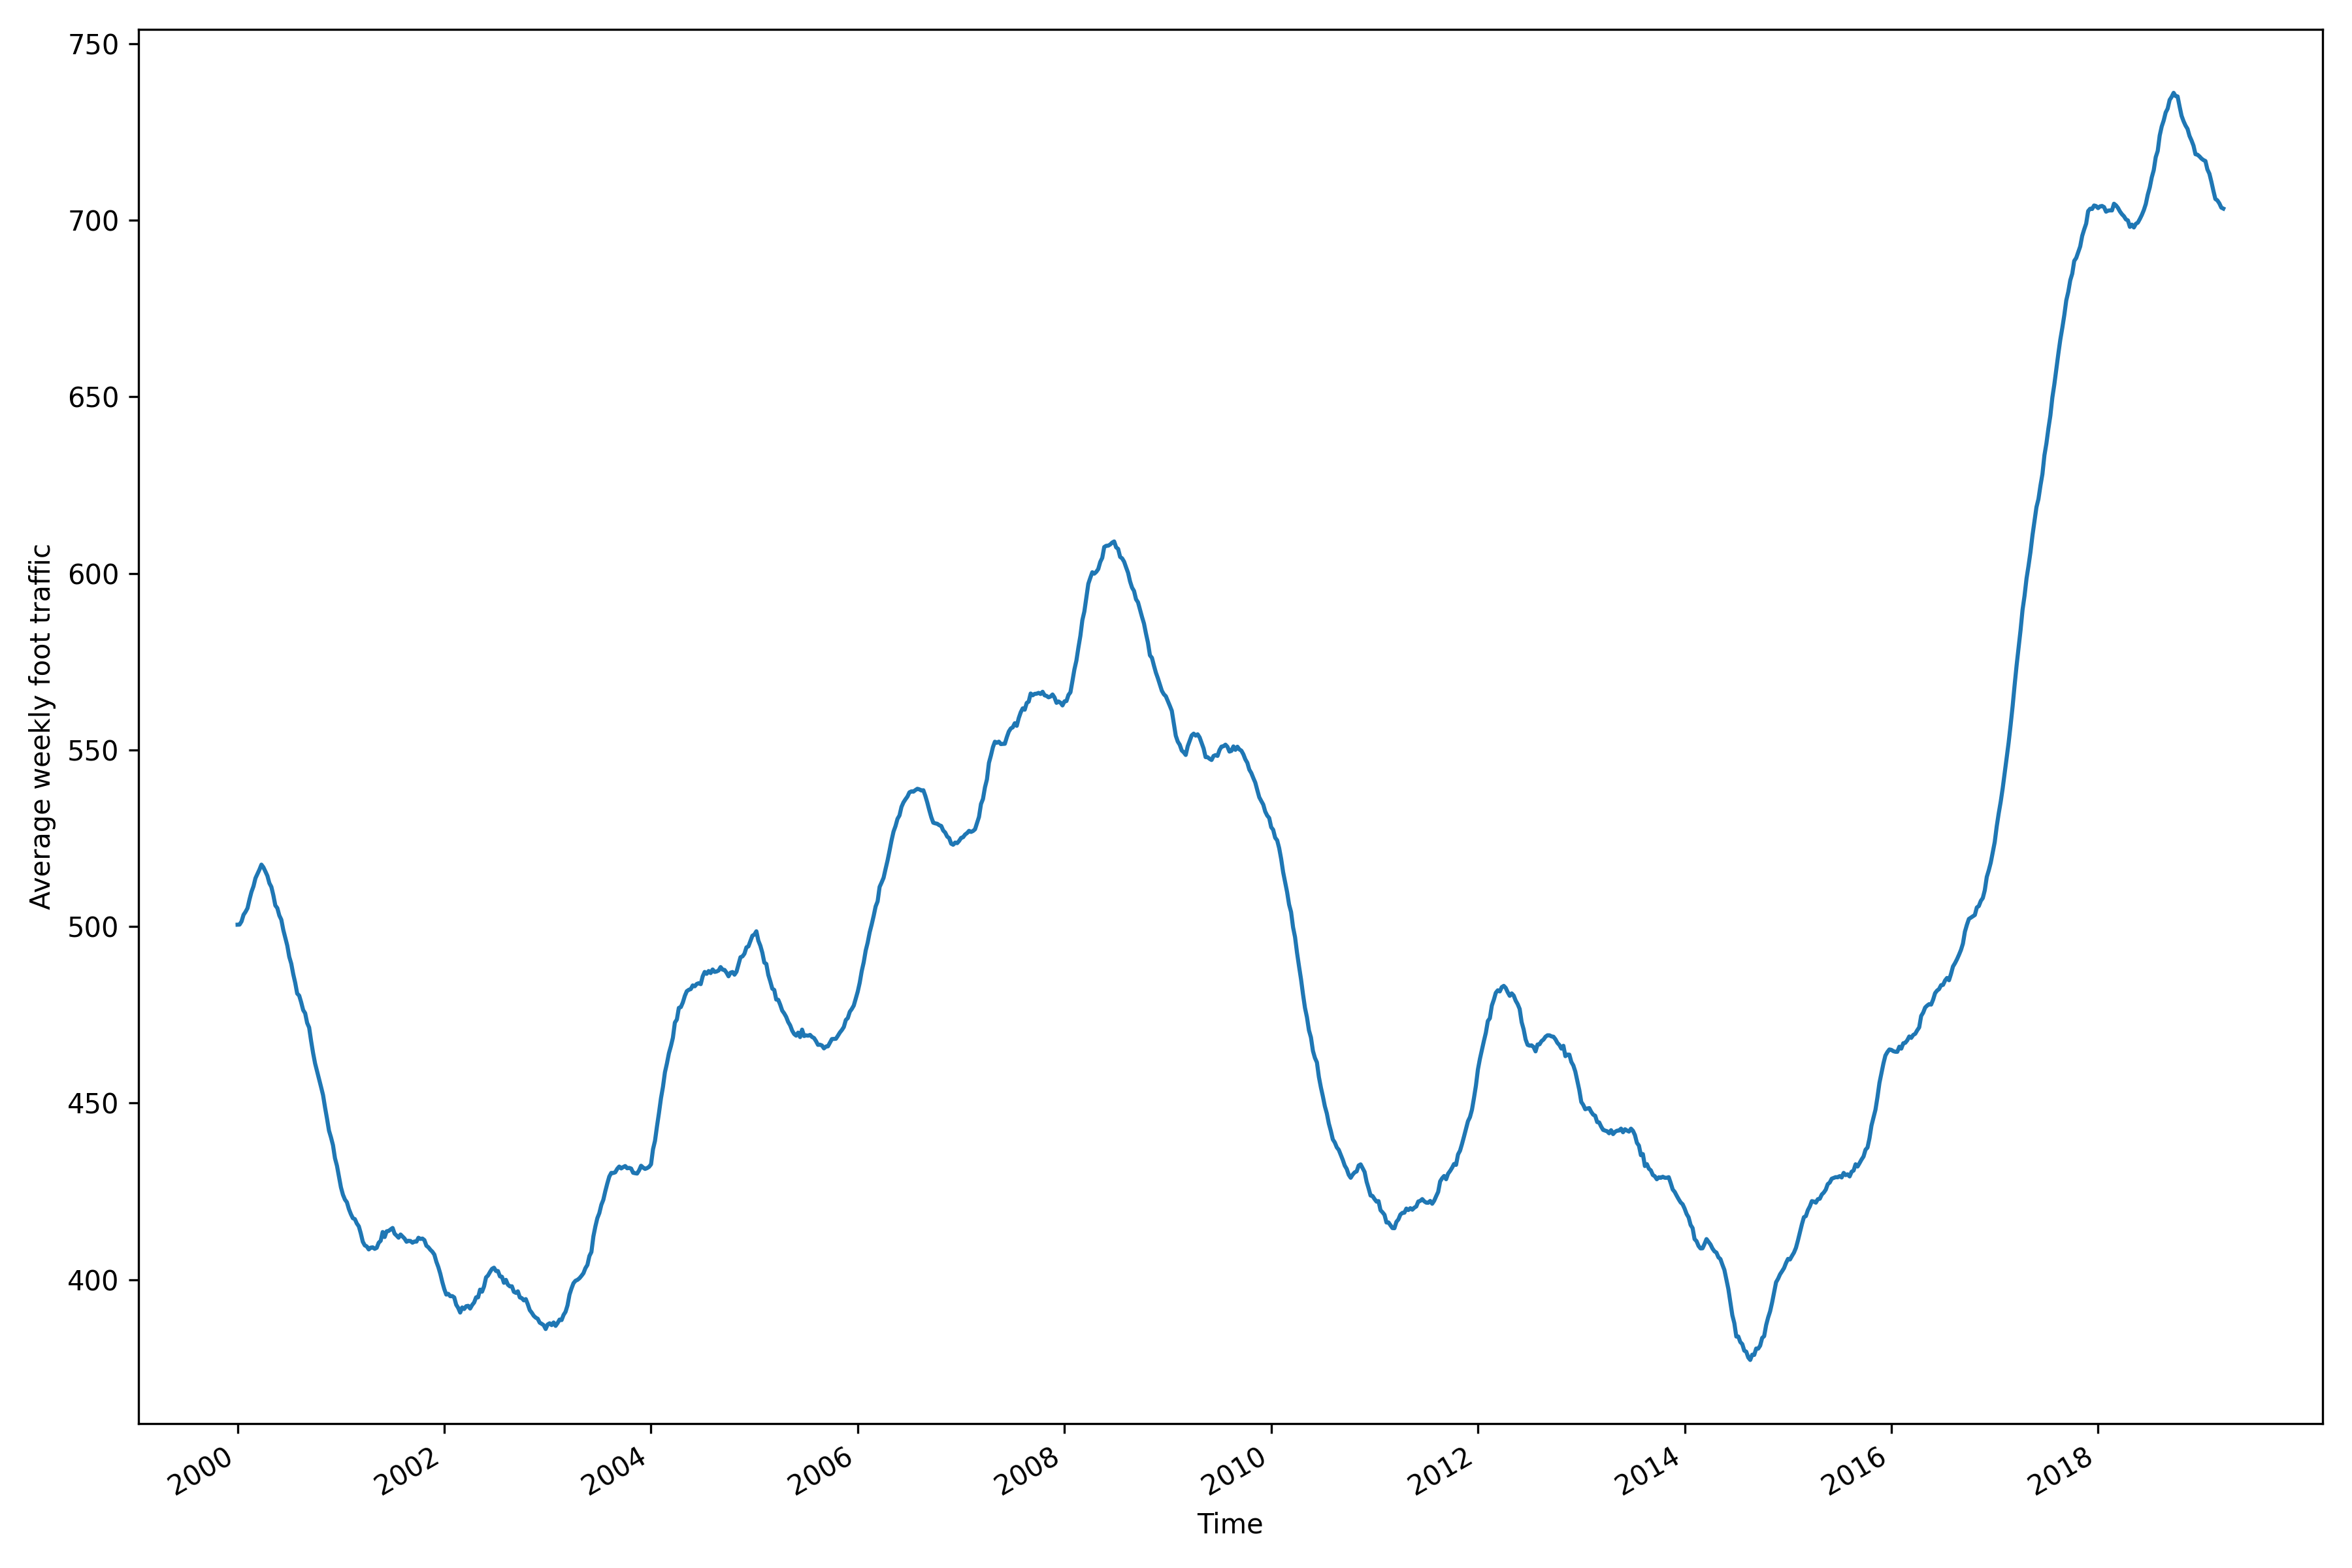 

* we can see a long-term trend with peaks and troughs along the way. We can intuitively say that this time series is not a stationary process, since we observe a trend over time. 
* Furthermore, there is no apparent cyclical pattern in the data, so we can rule out any seasonal effects for now.
* Again, in order to forecast the average weekly foot traffic, we need to identify the underlying process

### Steps to Identify the underlying process

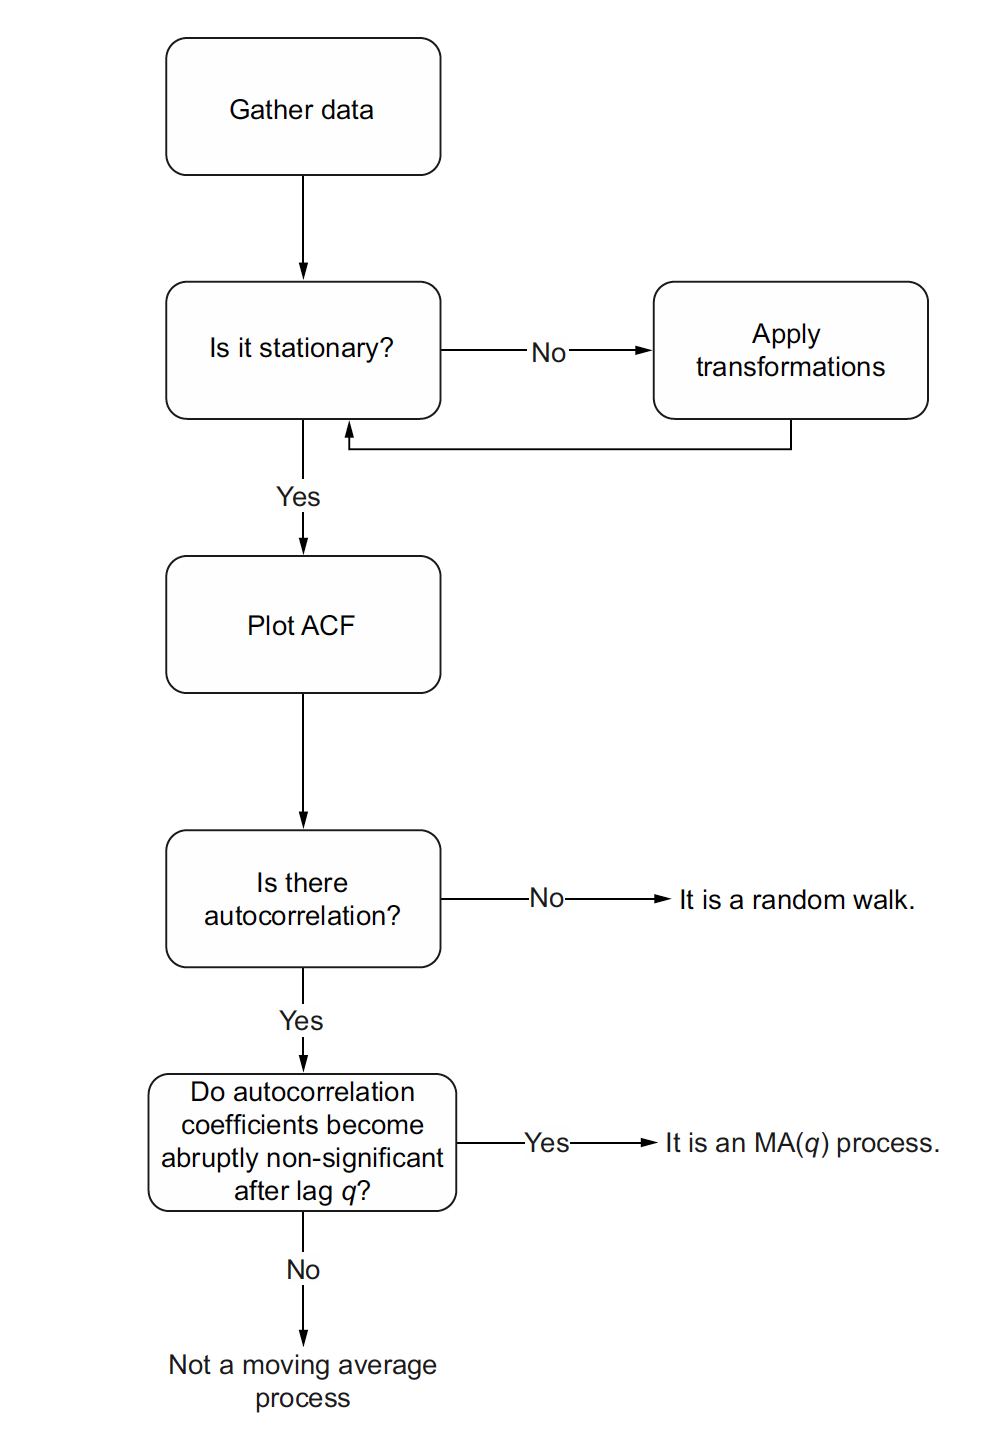

### Test Stationarity using ADF test

In [4]:
ADF_result = adfuller(df['foot_traffic'])

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -1.1758885999240747
p-value: 0.683880891789619


### Tranform data using the 1st Diff $(d=1)$

In [5]:
foot_traffic_diff = np.diff(df['foot_traffic'], n=1)

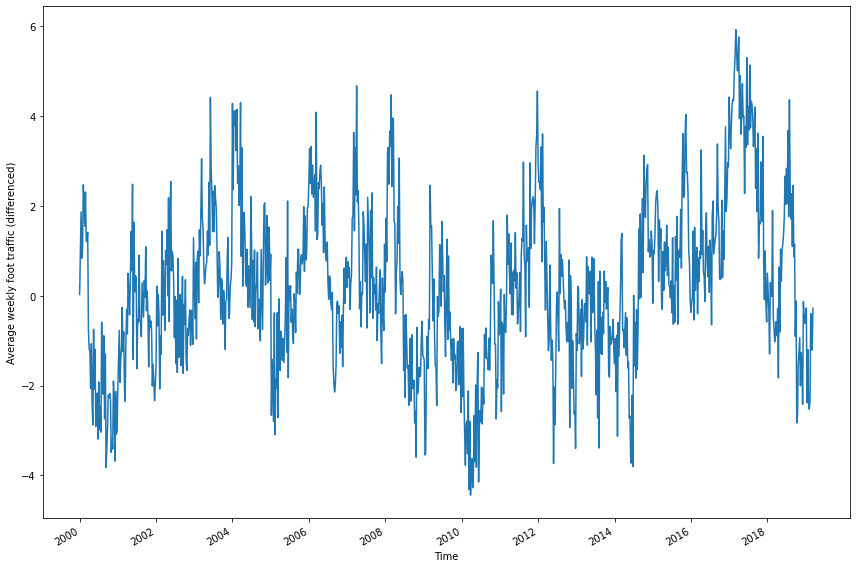

In [6]:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(foot_traffic_diff)
ax.set_xlabel('Time')
ax.set_ylabel('Average weekly foot traffic (differenced)')

plt.xticks(np.arange(0, 1000, 104), np.arange(2000, 2020, 2))

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/CH05_F05_peixeiro.png', dpi=300)

### Test after the difference

In [7]:
ADF_result = adfuller(foot_traffic_diff)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -5.268231347422044
p-value: 6.369317654781239e-06


* Time series now is staionary.
* we need to check the ACF plot.

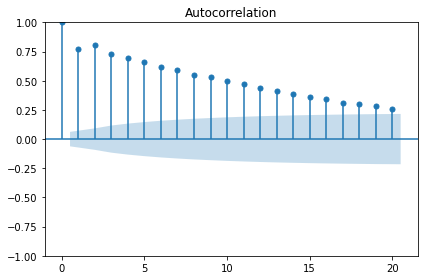

In [8]:
plot_acf(foot_traffic_diff, lags=20);

plt.tight_layout()

plt.savefig('figures/CH05_F06_peixeiro.png', dpi=300)

* we have significant autocorrelation coefficients beyond lag 0. Therefore, we know that our process is not a random walk. 

* Furthermore, you’ll notice that the coefficients are decaying exponentially as the lag increases
* Therefore, there is no lag at which the coefficients abruptly become nonsignificant.
* This means that we do not have a moving average process and that we are likely studying an autoregressive process.

## Defining the autoregressive process

An autoregressive process is a regression of a variable against itself. In a time
series, this means that the present value is linearly dependent on its past values.
The autoregressive process is denoted as $AR(p)$, where $p$ is the order. The general
expression of an AR(p) model is


$$
\Large y_t = C + \phi_1 y_{t–1} + \phi_2 y_{t–2} +⋅⋅⋅+ \phi_p y_{t–p} + \epsilon_t
$$

> Similar to the moving average process, the order p of an autoregressive process determines
the number of past values that affect the present value.

### First-order autoregressive process: $AR(p=1)$

If we have a first-order autoregressive process, also denoted as $AR(1)$, then the present value $y_t$ is only dependent on a constant $C$, the value at the previous timestep $\phi_1 y_{t –1}$, and some white noise $\epsilon_t$, as shown in equation:

$$
\Large y_t = C + \phi_1 y_{t –1} + \epsilon_t
$$

> This it is very similar to a random walk process, which we covered in chapter 3. In fact, if $\phi_1 = 1$, then this equation becomes

$$
\Large y_t = C +  y_{t –1} + \epsilon_t
$$

> Therefore, we can say that the random walk is a special case of an autoregressive process, where the order $p$ is $1$ and $\phi_1$ is equal to $1$.

> Notice also that if $C$ is not equal to $0$, then we have a random walk with drift.

## Second-order autoregressive process, or $AR(2)$
In the case of a second-order autoregressive process, or $AR(2)$, the present value $y_t$ is
linearly dependent on a constant $C$, the value at the previous timestep $\phi_1 y_{t –1}$, the value two timesteps prior $\phi_2 y_{t –2}$, and the present error term $\epsilon_t$, as shown in equation:

$$
\Large y_t = C + \phi_1 y_{t –1} + \phi_2 y_{t –2}+ \epsilon_t
$$

> The order $p$ influences the number of parameters that must be included in our model. As with a moving average process, we must find the right order of an autoregressive process in order to build the appropriate model.

## Finding the order of a stationary autoregressive process

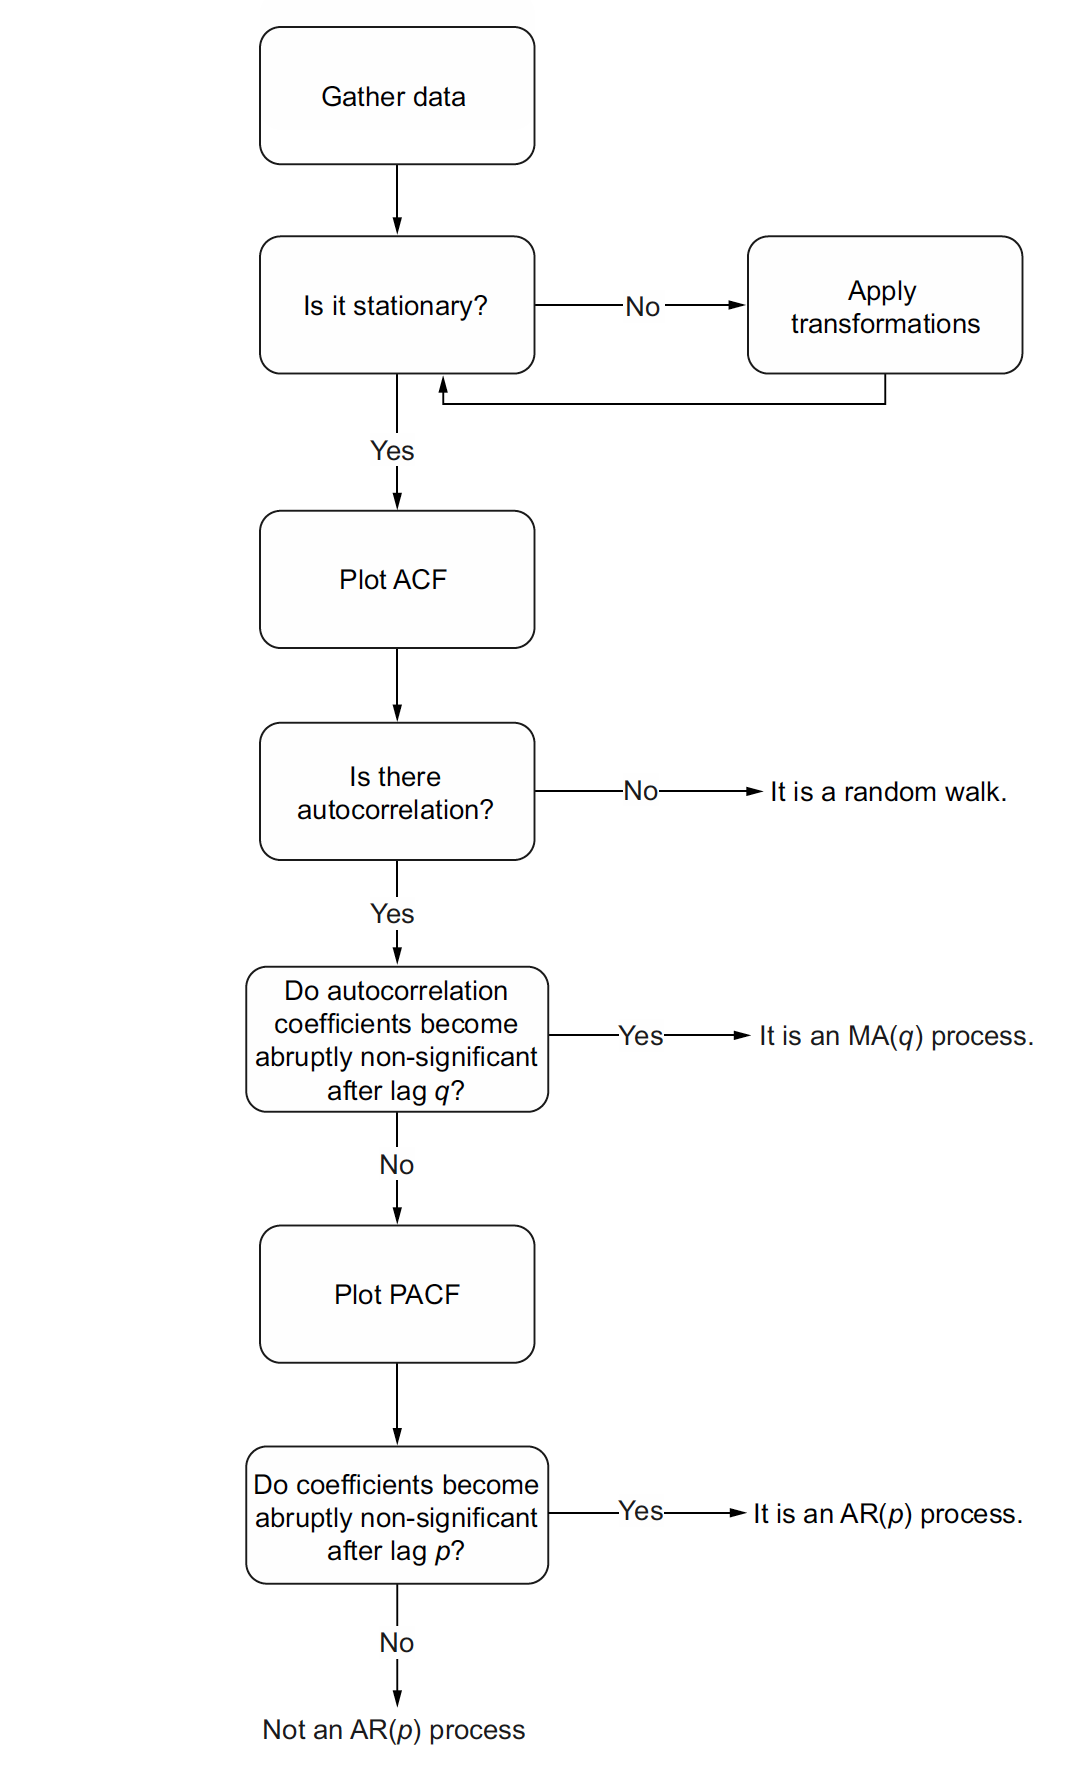

## The partial autocorrelation function (PACF)

* In an attempt to identify the order of a stationary autoregressive process, we used the $ ACF$ plot just as we did for a moving average process. Unfortunately, the $ACF$ plot cannot give us this information, and we must turn to the partial autocorrelation function $(PACF)$.

* Remember that the autocorrelation measures the linear relationship between lagged values of a time series. Consequently, the autocorrelation function measures how the correlation changes between two values as the lag is increased.

> To understand the partial autocorrelation function, let’s consider the following
scenario. Suppose we have the following $AR(2)$ process:


$$
\Large y_t =  0.33 y_{t –1} + 0.5y_{t –2}
$$


$$
\Large y_t =  0.33 y_{t –1} + 0.5y_{t –2}
$$
* We wish to measure how $y_t$ relates to $y_{t –2}$; in other words, we want to measure their correlation.
* This is done with the autocorrelation function (ACF). However, from the ACF plot of the differenced average weekly foot traffic at a retail store.
* Notice how the plot is slowly decaying. This is a behavior that we have not observed before, and it is indicative of an autoregressive process.
* Modeling an autoregressive process equation, we can see that $y_{t –1}$ also has an influence on $y_t$. Even more important, it also has an impact on the value of $y_{t –2}$, since in an $AR(2)$ process, each value depends on the previous two values. 
* Therefore, when we measure the autocorrelation between $y_t$ and $y_{t –2}$ using the $ACF$, we are not taking into account the fact that $y_{t –1}$ has an influence on both $y_t$ and $y_{t –2}$. This means that we are not measuring the true impact of $y_{t –2}$ on $y_t$. 

> To do so, we must remove the effect of $y_{t –1}$. Thus, we are measuring the partial
autocorrelation between $y_t$ and $y_{t –2}$.

### Partial autocorrelation
Partial autocorrelation measures the correlation between lagged values in a time
series when we remove the influence of correlated lagged values in between. We can
plot the partial autocorrelation function to determine the order of a stationary $AR(p)$
process. The coefficients will be non-significant after lag $p$.

### Simulation of Autoregressive process $AR(p=2)$

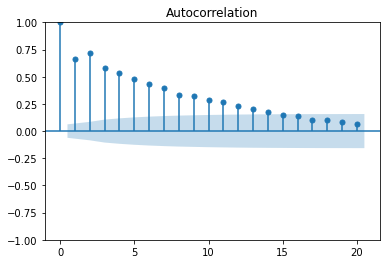

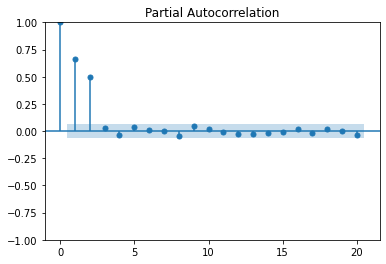

In [22]:
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_pacf
import numpy as np

np.random.seed(42)

ma2 = np.array([1,0,0]) # no moving average process 
ar2 = np.array([1, -0.33,-.5]) 

AR2_process = ArmaProcess(ar2, ma2).generate_sample(nsample=1000)

plot_acf(AR2_process, lags=20);
# Plot PACF
plot_pacf(AR2_process, lags=20);
plt.savefig('figures/CH05_F07_peixeiro.png', dpi=300)

## PACF for foot trafic differenced data

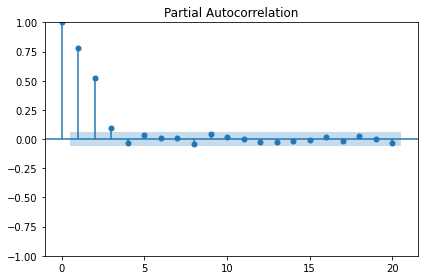

In [23]:
plot_pacf(foot_traffic_diff, lags=20);

plt.tight_layout()

plt.savefig('figures/CH05_F08_peixeiro.png', dpi=300)

### Split data training/test

In [24]:
df_diff = pd.DataFrame({'foot_traffic_diff': foot_traffic_diff})

train = df_diff[:-52]
test = df_diff[-52:]

print(len(train))
print(len(test))

947
52


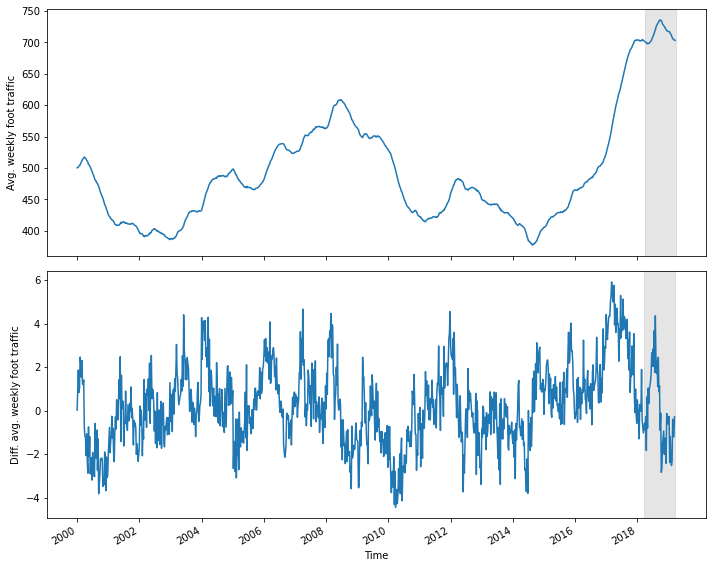

In [25]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 8))

ax1.plot(df['foot_traffic'])
ax1.set_xlabel('Time')
ax1.set_ylabel('Avg. weekly foot traffic')
ax1.axvspan(948, 1000, color='#808080', alpha=0.2)

ax2.plot(df_diff['foot_traffic_diff'])
ax2.set_xlabel('Time')
ax2.set_ylabel('Diff. avg. weekly foot traffic')
ax2.axvspan(947, 999, color='#808080', alpha=0.2)

plt.xticks(np.arange(0, 1000, 104), np.arange(2000, 2020, 2))

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/CH05_F09_peixeiro.png', dpi=300)

### Apply AR(3)

In [26]:
l=len(train)
ts=df["foot_traffic"]
model = SARIMAX(ts[:l], order=(3,0,0))
res = model.fit(disp=False)
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:           foot_traffic   No. Observations:                  947
Model:               SARIMAX(3, 0, 0)   Log Likelihood               -1360.757
Date:                Sun, 05 Mar 2023   AIC                           2729.514
Time:                        16:49:49   BIC                           2748.927
Sample:                             0   HQIC                          2736.912
                                - 947                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4347      0.029     49.724      0.000       1.378       1.491
ar.L2          0.1304      0.058      2.259      0.024       0.017       0.243
ar.L3         -0.5651      0.029    -19.581      0.0

## Forecasting an autoregressive process

In [27]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    end_idx = train_len
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))
            
        return pred_mean

    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'AR':
        pred_AR = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(3,0,0))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_AR.extend(oos_pred)
            
        return pred_AR

In [ ]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 1

pred_mean = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_AR = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'AR')

test['pred_mean'] = pred_mean
test['pred_last_value'] = pred_last_value
test['pred_AR'] = pred_AR

test.head()

KeyError: 'pred_mean'

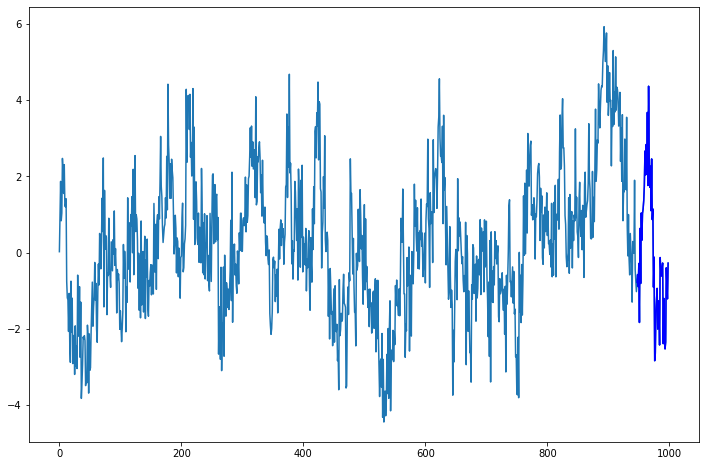

In [28]:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(df_diff['foot_traffic_diff'])
ax.plot(test['foot_traffic_diff'], 'b-', label='actual')
ax.plot(test['pred_mean'], 'g:', label='mean')
ax.plot(test['pred_last_value'], 'r-.', label='last')
ax.plot(test['pred_AR'], 'k--', label='AR(3)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Diff. avg. weekly foot traffic')

ax.axvspan(947, 998, color='#808080', alpha=0.2)

ax.set_xlim(920, 999)

plt.xticks([936, 988],[2018, 2019])

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/CH05_F10_peixeiro.png', dpi=300)

### Evaluate

In [86]:
from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(test['foot_traffic_diff'], test['pred_mean'])
mse_last = mean_squared_error(test['foot_traffic_diff'], test['pred_last_value'])
mse_AR = mean_squared_error(test['foot_traffic_diff'], test['pred_AR'])

print(mse_mean, mse_last, mse_AR)

3.1079979374701447 1.448730118495964 0.9242479164116852


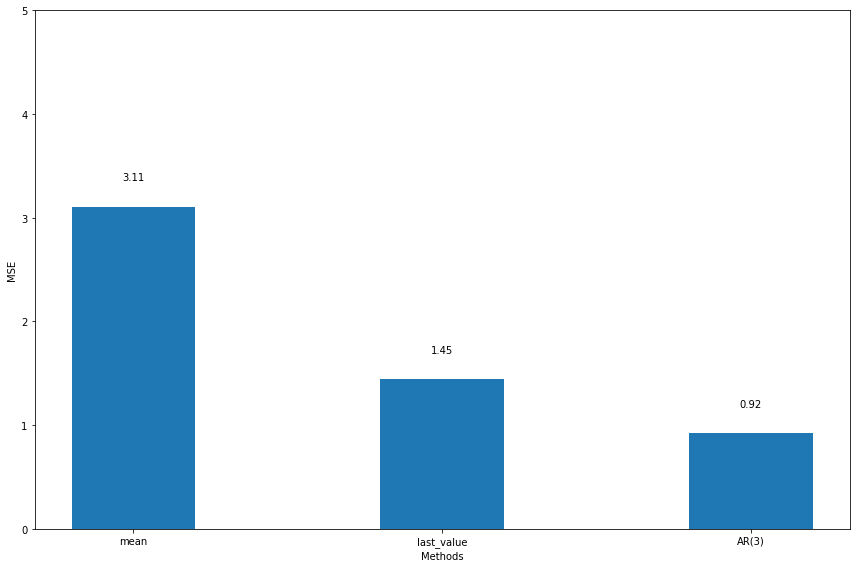

In [88]:
fig, ax = plt.subplots(figsize=(12,8))

x = ['mean', 'last_value', 'AR(3)']
y = [mse_mean, mse_last, mse_AR]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Methods')
ax.set_ylabel('MSE')
ax.set_ylim(0, 5)

for index, value in enumerate(y):
    plt.text(x=index, y=value+0.25, s=str(round(value, 2)), ha='center')

plt.tight_layout()

## Forecast actual data (undifferenced)

In [89]:
df['pred_foot_traffic'] = pd.Series()
df['pred_foot_traffic'][948:] = df['foot_traffic'].iloc[948] + test['pred_AR'].cumsum()

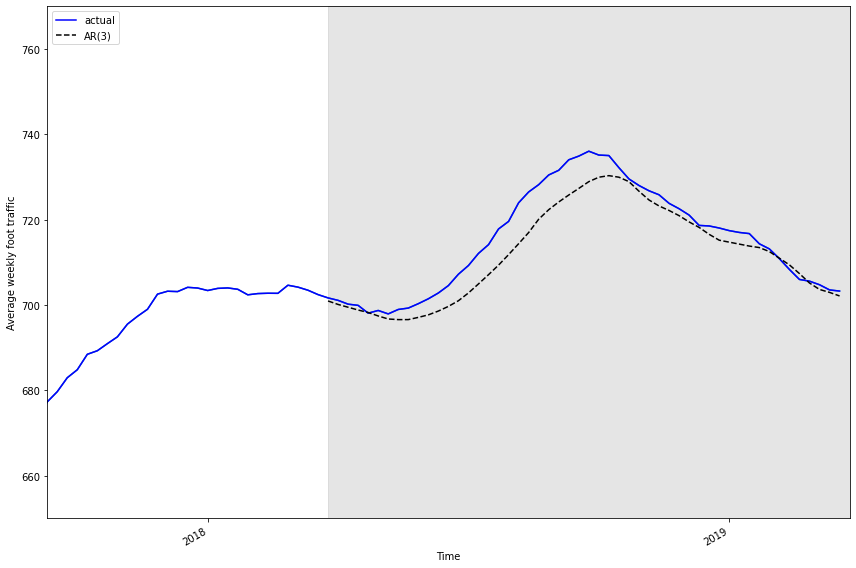

In [92]:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(df['foot_traffic'])
ax.plot(df['foot_traffic'], 'b-', label='actual')
ax.plot(df['pred_foot_traffic'], 'k--', label='AR(3)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Average weekly foot traffic')

ax.axvspan(948, 1000, color='#808080', alpha=0.2)

ax.set_xlim(920, 1000)
ax.set_ylim(650, 770)

plt.xticks([936, 988],[2018, 2019])

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/CH05_F11_peixeiro.png', dpi=300)

## Evaluation on actual scale

In [102]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

mae_AR_undiff = mean_absolute_error(df['foot_traffic'][948:], df['pred_foot_traffic'][948:])
mape_AR_undiff = mean_absolute_percentage_error(df['foot_traffic'][948:], df['pred_foot_traffic'][948:])

print('MAE:', "%.2f" % mae_AR_undiff)
print('MAPE:',"%.2f" % (mape_AR_undiff*100),'%')

MAE: 3.48
MAPE: 0.48 %


## Summary
* An autoregressive process states that the present value is linearly dependent on its past values and an error term.
* If the $ACF$ plot of a stationary process shows a slow decay, then you likely have an autoregressive process.
* The partial autocorrelation measures the correlation between two lagged values of a time series when you remove the effect of the other autocorrelated lagged values.
* Plotting the $PACF$ of a stationary autoregressive process will show the order $p$ of the process. The coefficients will be significant up until lag $p$ only.